In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
input_path = 'Input/'

t_line_drug= input_path + 'patient_oncologicalTreatmentLine_drugs.csv'
d_no_onco = input_path + 'patient_nonOncologycalTreatments.csv'

treatment_line_drug = pd.read_csv(t_line_drug, delimiter=",")
drug_no_onco = pd.read_csv(d_no_onco, delimiter=",")

# Preprocessing non-oncological drugs

In [3]:
#treatment_line_drug['drug_name'] = treatment_line_drug['drug_name'].str.lower()
#drug_no_onco['drug_name'] = drug_no_onco['drug_name'].str.lower()

replacement_mapping_dict = {
    'Enalaprile': 'Enalapril',
    'Atenolole': 'Atenolol',
    'Azitromicina': 'Azithromycin',
    'Immunoglobulin_g': 'Human_immunoglobulin_g',
}
drug_no_onco['drug_name'].replace(replacement_mapping_dict, inplace=True)
drug_no_onco = drug_no_onco.loc[~drug_no_onco.drug_name.isin(['Antibiotic','Analgesic','Antibiotics','Insulin','Corticoids'])]

display(treatment_line_drug.shape, treatment_line_drug.head())
display(drug_no_onco.shape, drug_no_onco.head())

(1874, 3)

,patient_id,oncologicalTreatmentLine_id,drug_name
0,1003706,1,Cisplatin
1,1003706,1,Pemetrexed
2,1003706,2,Docetaxel
3,1007602,3,Carboplatin
4,1007602,3,Etoposide


(1290, 2)

,patient_id,drug_name
0,1098173,Omeprazole
1,1098173,Ranitidine
2,1100890,Omeprazole
3,1103334,Omeprazole
4,1103334,Enalapril


# Select drugs by each line

In [4]:
cancer_treatment = pd.merge(treatment_line_drug[['patient_id', 'oncologicalTreatmentLine_id']], drug_no_onco, how='inner',
                          on=['patient_id'])
cancer_treatment.drop_duplicates(keep='first', inplace=True)
cancer_treatment = pd.concat([cancer_treatment, treatment_line_drug])

cancer_treatment = cancer_treatment.sort_values(by=['oncologicalTreatmentLine_id'])
cancer_treatment

,patient_id,oncologicalTreatmentLine_id,drug_name
0,1003706,1,Cisplatin
1,1003706,1,Pemetrexed
2,1003706,2,Docetaxel
3,1007602,3,Carboplatin
4,1007602,3,Etoposide
...,...,...,...
2682,994263,1236,Simvastatin
1871,994263,1236,Docetaxel
2683,998317,1237,Omeprazole
1872,998317,1237,Cisplatin


In [5]:
df_drug = cancer_treatment.groupby(by=['patient_id','oncologicalTreatmentLine_id']).agg(lambda x: x.tolist()).reset_index()
df_drug

,patient_id,oncologicalTreatmentLine_id,drug_name
0,3561,768,"[Etoposide, Omeprazole, Acetaminophen, Simvast..."
1,3877,787,"[Omeprazole, Atenolol, Carboplatin, Etoposide]"
2,6203,949,"[Cisplatin, Omeprazole, Vinorelbine]"
3,6203,950,"[Crizotinib, Omeprazole]"
4,8359,1172,"[Furosemide, Carboplatin]"
...,...,...,...
1232,2819894,715,"[Pembrolizumab, Enalapril]"
1233,2819955,716,"[Vinorelbine, Carboplatin, Omeprazole]"
1234,2819955,717,"[Gemcitabine, Omeprazole, Carboplatin]"
1235,2822207,718,"[Cisplatin, Vinorelbine, Omeprazole]"


In [6]:
onco_drug = set(treatment_line_drug.drug_name.unique())
set_drugs = set()
for i in range(df_drug.shape[0]):
    # == write the number of drug of the treatment
    drugs = df_drug.drug_name[i]
    drugs.sort()    
    df_drug.at[i,'n_drugs'] = len(drugs)
    #df_drug.at[i,'drug_name']=drugs
    
    # == write the number of oncological drugs of the treatment
    set_d = list(set.intersection(onco_drug, set(drugs)))
    set_d.sort()    
    df_drug.at[i,'n_drug_onco'] = len(set_d)
    #df_drug.at[i,'oncological_drug'] = ', '.join(list(set_d))
    
    # == write the treatment order by onco_drug + non-onco_drug
    non_onco_drug = list(set(drugs) - set(set_d))
    non_onco_drug.sort()
    df_drug.at[i,'treatment'] = ', '.join(set_d + non_onco_drug)
    set_drugs.update(set(set_d + non_onco_drug))
    
df_drug['n_drugs'] = df_drug['n_drugs'].astype(int)
df_drug['n_drug_onco'] = df_drug['n_drug_onco'].astype(int)
df_drug = df_drug.loc[df_drug['n_drugs']>2]
df_drug = df_drug.sort_values(by=['n_drug_onco', 'n_drugs'], ascending=False)
df_drug

,patient_id,oncologicalTreatmentLine_id,drug_name,n_drugs,n_drug_onco,treatment
262,429640,814,"[Cisplatin, Docetaxel, Pemetrexed, Vinorelbine]",4,4,"Cisplatin, Docetaxel, Pemetrexed, Vinorelbine"
575,816028,1158,"[Carboplatin, Dexamethasone, Lorazepam, Omepra...",6,3,"Carboplatin, Paclitaxel, Pemetrexed, Dexametha..."
601,865317,1189,"[Cisplatin, Docetaxel, Omeprazole, Pemetrexed]",4,3,"Cisplatin, Docetaxel, Pemetrexed, Omeprazole"
233,375428,781,"[Carboplatin, Paclitaxel, Vinorelbine]",3,3,"Carboplatin, Paclitaxel, Vinorelbine"
614,925591,1207,"[Cisplatin, Gemcitabine, Vinorelbine]",3,3,"Cisplatin, Gemcitabine, Vinorelbine"
...,...,...,...,...,...,...
1186,2771360,668,"[Nivolumab, Omeprazole, Simvastatin]",3,1,"Nivolumab, Omeprazole, Simvastatin"
1187,2771360,669,"[Omeprazole, Pembrolizumab, Simvastatin]",3,1,"Pembrolizumab, Omeprazole, Simvastatin"
1188,2771360,670,"[Carboplatin, Omeprazole, Simvastatin]",3,1,"Carboplatin, Omeprazole, Simvastatin"
1222,2811447,705,"[Atorvastatin, Nivolumab, Omeprazole]",3,1,"Nivolumab, Atorvastatin, Omeprazole"


In [7]:
treatment = df_drug[['treatment', 'n_drugs']]
treatment.drop_duplicates(keep='first', inplace=True)
#treatment = treatment.loc[treatment.astype(str).drop_duplicates().index].reset_index()
#treatment = treatment.drop(columns=['index'])
treatment

C:\Users\rivasa\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,treatment,n_drugs
262,"Cisplatin, Docetaxel, Pemetrexed, Vinorelbine",4
575,"Carboplatin, Paclitaxel, Pemetrexed, Dexametha...",6
601,"Cisplatin, Docetaxel, Pemetrexed, Omeprazole",4
233,"Carboplatin, Paclitaxel, Vinorelbine",3
614,"Cisplatin, Gemcitabine, Vinorelbine",3
...,...,...
1173,"Paclitaxel, Methylprednisolone, Omeprazole",3
1174,"Nivolumab, Methylprednisolone, Omeprazole",3
1175,"Carboplatin, Atenolol, Simvastatin",3
1187,"Pembrolizumab, Omeprazole, Simvastatin",3


In [8]:
treatment[['treatment']].to_csv('treatments/cancer_treatments.csv', index=False)

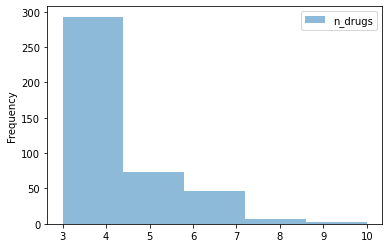

In [9]:
df = treatment[['n_drugs']]
ax = df.plot.hist(bins=5, alpha=0.5)

In [10]:
set_drugs

{'Acetaminophen',
 'Afatinib',
 'Alectinib',
 'Allopurinol',
 'Amlodipine',
 'Amoxicillin',
 'Atenolol',
 'Atorvastatin',
 'Azithromycin',
 'Bevacizumab',
 'Carboplatin',
 'Ceftriaxone',
 'Ceritinib',
 'Ciprofloxacin',
 'Cisplatin',
 'Crizotinib',
 'Dexamethasone',
 'Dexketoprofen',
 'Docetaxel',
 'Enalapril',
 'Enoxaparin',
 'Etoposide',
 'Fentanyl',
 'Furosemide',
 'Gemcitabine',
 'Gentamicin',
 'Human_immunoglobulin_g',
 'Ibuprofen',
 'Ipilimumab',
 'Levofloxacin',
 'Lorazepam',
 'Lormetazepam',
 'Metformin',
 'Methylprednisolone',
 'Metoclopramide',
 'Necitumumab',
 'Nivolumab',
 'Omeprazole',
 'Ondansetron',
 'Osimertinib',
 'Paclitaxel',
 'Pembrolizumab',
 'Pemetrexed',
 'Prednisone',
 'Ranitidine',
 'Salbutamol',
 'Simvastatin',
 'Spironolactone',
 'Sulfamethoxazole',
 'Tramadol',
 'Trimethoprim',
 'Vinorelbine'}

In [11]:
drugBank_id_name = pd.read_csv('../store_data/drug/drugBank_id_name.csv', delimiter=",")
display(drugBank_id_name.shape, drugBank_id_name.head())

(14315, 2)

,DrugBankID,DrugName
0,DB00001,Lepirudin
1,DB00002,Cetuximab
2,DB00003,Dornase_alfa
3,DB00004,Denileukin_diftitox
4,DB00005,Etanercept


In [14]:
drug_treatment = pd.DataFrame(set_drugs, columns=['DrugName'])
drug_id = pd.merge(drugBank_id_name,drug_treatment,on='DrugName')
drug_id

,DrugBankID,DrugName
0,DB00028,Human_immunoglobulin_g
1,DB00112,Bevacizumab
2,DB00186,Lorazepam
3,DB00193,Tramadol
4,DB00207,Azithromycin
5,DB00316,Acetaminophen
6,DB00331,Metformin
7,DB00335,Atenolol
8,DB00338,Omeprazole
9,DB00361,Vinorelbine
